# Bootstraping no Pandas

Esse notebook tem como objetivo ilustrar um exemplo de como a técnica de bootstraping pode ser empregada utilizando a biblioteca `Pandas`.

---

## Pré-processamento:

Lendo e padronizando os dados:

In [0]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler

iris = load_iris() # variável iris será do tipo bunch
dados = iris.data
alvo = iris.target

ss = StandardScaler()
dados = ss.fit_transform(iris.data)

Transformando o dataset do formato `sklearn.utils.Bunch` para `pandas.DataFrame`:

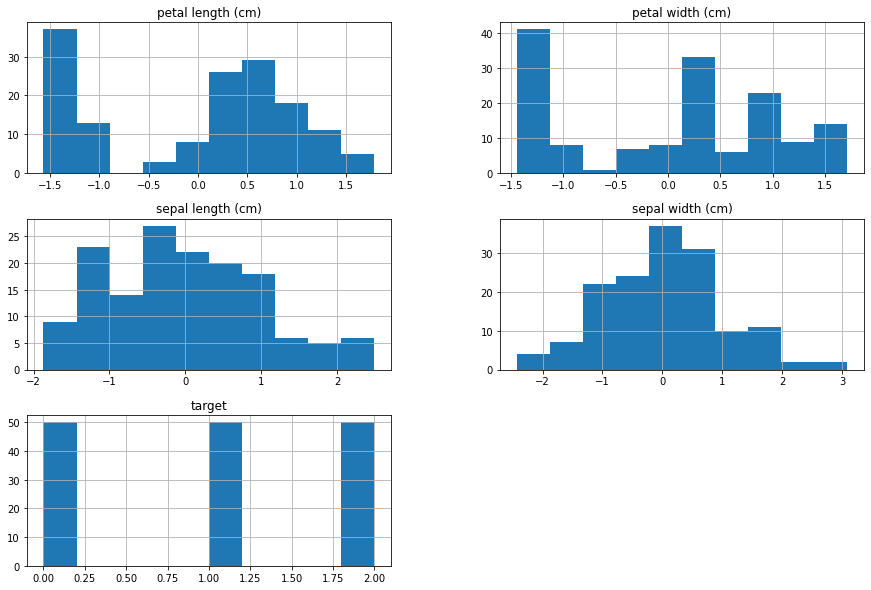

In [0]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

df = pd.DataFrame(data=np.c_[dados, alvo], columns= iris['feature_names'] + ['target'])

plt.rcParams['figure.figsize'] = [15, 10]
_ = df.hist()

Transformando o dataset em um problema binário (ao invés de termos classes tipo 0, tipo 1 e tipo 2, teremos as classes tipo 1 e tipo não 1). Para isso vamos substituir todas as ocorrências da classe 2 para classe 0:

0.0    100
1.0     50
Name: target, dtype: int64

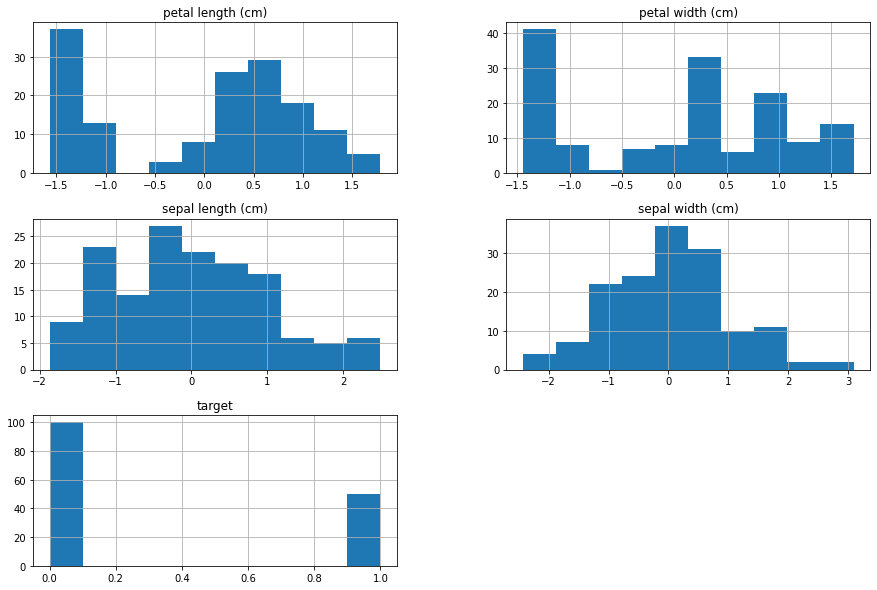

In [0]:
df.target = df.target.replace(to_replace = 2, value = 0)
_ = df.hist()
df['target'].value_counts()



---

## Cálculo de acurácia utilizando Bootstraping

Vamos utilizar um algoritmo de classificação simples, o KNN para K=5:

In [0]:
from sklearn.neighbors import KNeighborsClassifier

_5nn = KNeighborsClassifier(n_neighbors=5)

Separarando os dados em 80% treino e 20% teste utilizando `train_test_split` e criando um novo dataframe só de instancias de treino, para facilitar o manuseio:

0.0    80
1.0    40
Name: target, dtype: int64

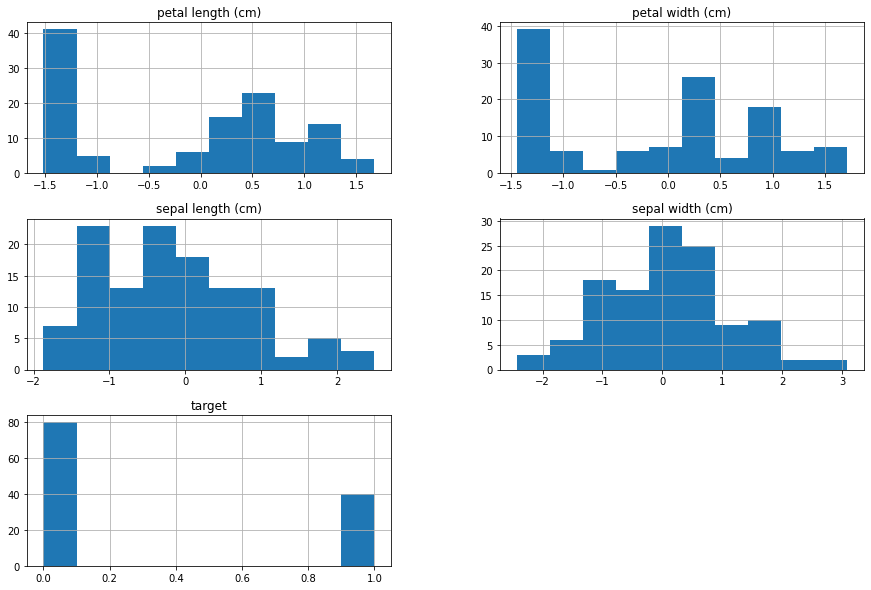

In [0]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split

p_treino = 0.8
p_teste = 1 - p_treino

X = df.iloc[:, 0:4]
y = df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=p_teste)

data_train = pd.DataFrame(data=np.c_[X_train, y_train], columns= iris['feature_names'] + ['target'])
_ = data_train.hist()
data_train['target'].value_counts()

Balanceando as classes no conj. de treino

In [0]:
classe_0 = data_train[data_train['target'] == 0]
classe_1 = data_train[data_train['target'] == 1]
data_train = pd.concat([classe_0, classe_1.sample(n=80, replace=True)])

X_train, y_train = data_train.iloc[:, 0:4], data_train.iloc[:, -1]

data_train['target'].value_counts()


1.0    80
0.0    80
Name: target, dtype: int64

Calculando acurácia:

In [0]:
_5nn.fit(X_train, y_train)  
y_pred = _5nn.predict(X_test)
acc = balanced_accuracy_score(y_test, y_pred)
print("Acurácia do classificador na amostra: %.2f%%" % (acc*100))

Acurácia do classificador na amostra: 92.50%


Será que a acurácia real do modelo é realmente 92.50%? Vamos verificar utilizando Bootstrap de tamanho 1000:

In [0]:
no_exemplos = df.shape[0]
p_treino = 0.8
p_teste = 1 - p_treino
no_bootstrap = 1000

scores = []
for i in range(0, no_bootstrap):
  amostra = df.sample(n = no_exemplos, replace=True) # Obtendo amostra do bootstrap
  
  X = amostra.iloc[:, 0:4] # Separando em dados 
  y = amostra.iloc[:, -1]  # e variável alvo
 
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=p_teste) # Split dos dados

  data_train = pd.DataFrame(data=np.c_[X_train, y_train], columns= iris['feature_names'] + ['target']) # Criando um dataframe com os dados de treino
  classe_0 = data_train[data_train['target'] == 0]
  classe_1 = data_train[data_train['target'] == 1]
  data_train = pd.concat([classe_0, classe_1.sample(n=80, replace=True)]) # superamostragem

  X_train, y_train = data_train.iloc[:, 0:4], data_train.iloc[:, -1] # reatribuição dos dados pra treino (agora superamostrados)

  _5nn.fit(X_train, y_train)  
  y_pred = _5nn.predict(X_test)
  scores.append(balanced_accuracy_score(y_test, y_pred))

print("Score do classificador utilizando Bootstrap de tamanho %d: %.2f%%" % (no_bootstrap, np.mean(scores)*100))

Score do classificador utilizando Bootstrap de tamanho 1000: 94.84%


Com o bootstrap verificamos que na verdade a acurácia real não é 92.5%, e sim tende ao valor 94.84%.



---

## Matriz de confusão:

Podemos calcular a matriz de confusão para cada fold, e soma-las para obter a matriz de confusão da operação de bootstrap:

In [0]:
from sklearn.metrics import confusion_matrix

no_exemplos = df.shape[0]
p_treino = 0.8
no_bootstrap = 1000

matriz_conf = np.array([[0,0], [0,0]])

scores = []
for i in range(0, no_bootstrap):
  amostra = df.sample(n = no_exemplos, replace=True) # Obtendo amostra
  
  X = amostra.iloc[:, 0:4]
  y = amostra.iloc[:, -1]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=p_teste)

  data_train = pd.DataFrame(data=np.c_[X_train, y_train], columns= iris['feature_names'] + ['target'])
  classe_0 = data_train[data_train['target'] == 0]
  classe_1 = data_train[data_train['target'] == 1]
  data_train = pd.concat([classe_0, classe_1.sample(n=80, replace=True)])

  X_train, y_train = data_train.iloc[:, 0:4], data_train.iloc[:, -1]

  _5nn.fit(X_train, y_train)
  y_pred = _5nn.predict(X_test)
  scores.append(balanced_accuracy_score(y_test, y_pred))
  matriz_conf += confusion_matrix(y_test, y_pred, labels=[0, 1])

print("Score do classificador utilizando Bootstrap de tamanho %d: %.2f%%" % (no_bootstrap, np.mean(scores)*100))
print("Matriz de confusão:")
print(matriz_conf)

Score do classificador utilizando Bootstrap de tamanho 1000: 94.76%
Matriz de confusão:
[[18726  1317]
 [  379  9578]]
